In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
%load_ext rpy2.ipython
%R library(ggplot2)

R[write to console]: Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang



array(['ggplot2', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], dtype='<U9')

In [3]:
df = pd.read_csv('../data/historical/Batting.csv')
games = pd.read_csv('../data/historical/Teams.csv')

In [41]:
revenue = {1990: 1.3461, 1991: 1.4591, 1992: 1.5836, 1993: 1.7745, 1994: 1.6870, 
           1995: 1.4105, 1996: 1.8472, 1997: 2.2158, 1998: 2.6633, 1999: 2.8279, 2000: 3.1776, 2001: 3.5830, 
           2002: 3.65, 2003: 3.878, 2004 : 4.27
            }
rev = pd.DataFrame.from_dict(revenue, orient='index', columns = ['Revenue'])
rev.index.name = 'yearID'
rev = rev.reset_index()
rev.to_csv('../data/revenue.csv')

In [40]:
join

,yearID,stint,AB,R,H,2B,3B,HR,RBI,SB,...,BB,SO,IBB,HBP,SH,SF,GIDP,G,r_G,hr_G
0,1871,115,10822,2659,3101,434,239,47,1783.0,441.0,...,393,175.0,0.0,0.0,0.0,0.0,74.0,254,10.468504,0.185039
1,1872,172,15663,3390,4467,581,145,37,2132.0,269.0,...,263,264.0,0.0,0.0,0.0,0.0,97.0,366,9.262295,0.101093
2,1873,128,16959,3580,4926,570,211,47,2331.0,314.0,...,335,278.0,0.0,0.0,0.0,0.0,122.0,398,8.994975,0.118090
3,1874,126,19104,3470,5224,634,194,40,2252.0,242.0,...,238,357.0,0.0,0.0,0.0,0.0,107.0,464,7.478448,0.086207
4,1875,248,26833,4234,6812,839,273,40,2710.0,629.0,...,249,675.0,0.0,0.0,0.0,0.0,142.0,690,6.136232,0.057971
5,1876,127,20121,3066,5338,633,181,40,1984.0,0.0,...,336,589.0,0.0,0.0,0.0,0.0,0.0,520,5.896154,0.076923
6,1877,106,13667,2040,3705,431,204,24,1410.0,0.0,...,345,726.0,0.0,0.0,0.0,0.0,0.0,360,5.666667,0.066667
7,1878,83,13644,1904,3539,481,132,23,1331.0,0.0,...,364,1081.0,0.0,0.0,0.0,0.0,0.0,368,5.173913,0.062500
8,1879,135,24155,3409,6171,958,317,58,2357.0,0.0,...,508,1843.0,0.0,0.0,0.0,0.0,0.0,642,5.309969,0.090343
9,1880,143,24301,3191,5946,980,328,62,2223.0,0.0,...,740,1993.0,0.0,0.0,0.0,0.0,0.0,680,4.692647,0.091176


In [4]:
games = games[['yearID', 'teamID', 'G']]

In [5]:
game_gr = games.groupby('yearID').sum().reset_index()
gr = df.groupby('yearID').sum().reset_index().drop('G', axis = 1)
join = pd.merge(gr, game_gr, on = 'yearID', how = 'left')

In [6]:
join['r_G'] = join.R / join.G
join['hr_G'] = join.HR / join.G

In [7]:
era = join.loc[(join.yearID > 1987) ]
era['steroidFlag'] = np.where(era.yearID < 1993, 'no', 'yes')

In [8]:
era.groupby('steroidFlag').agg('mean')[['hr_G']]
(1.048333 - 0.760441)/0.760441

0.37858558389145236

In [9]:
%R -i era 

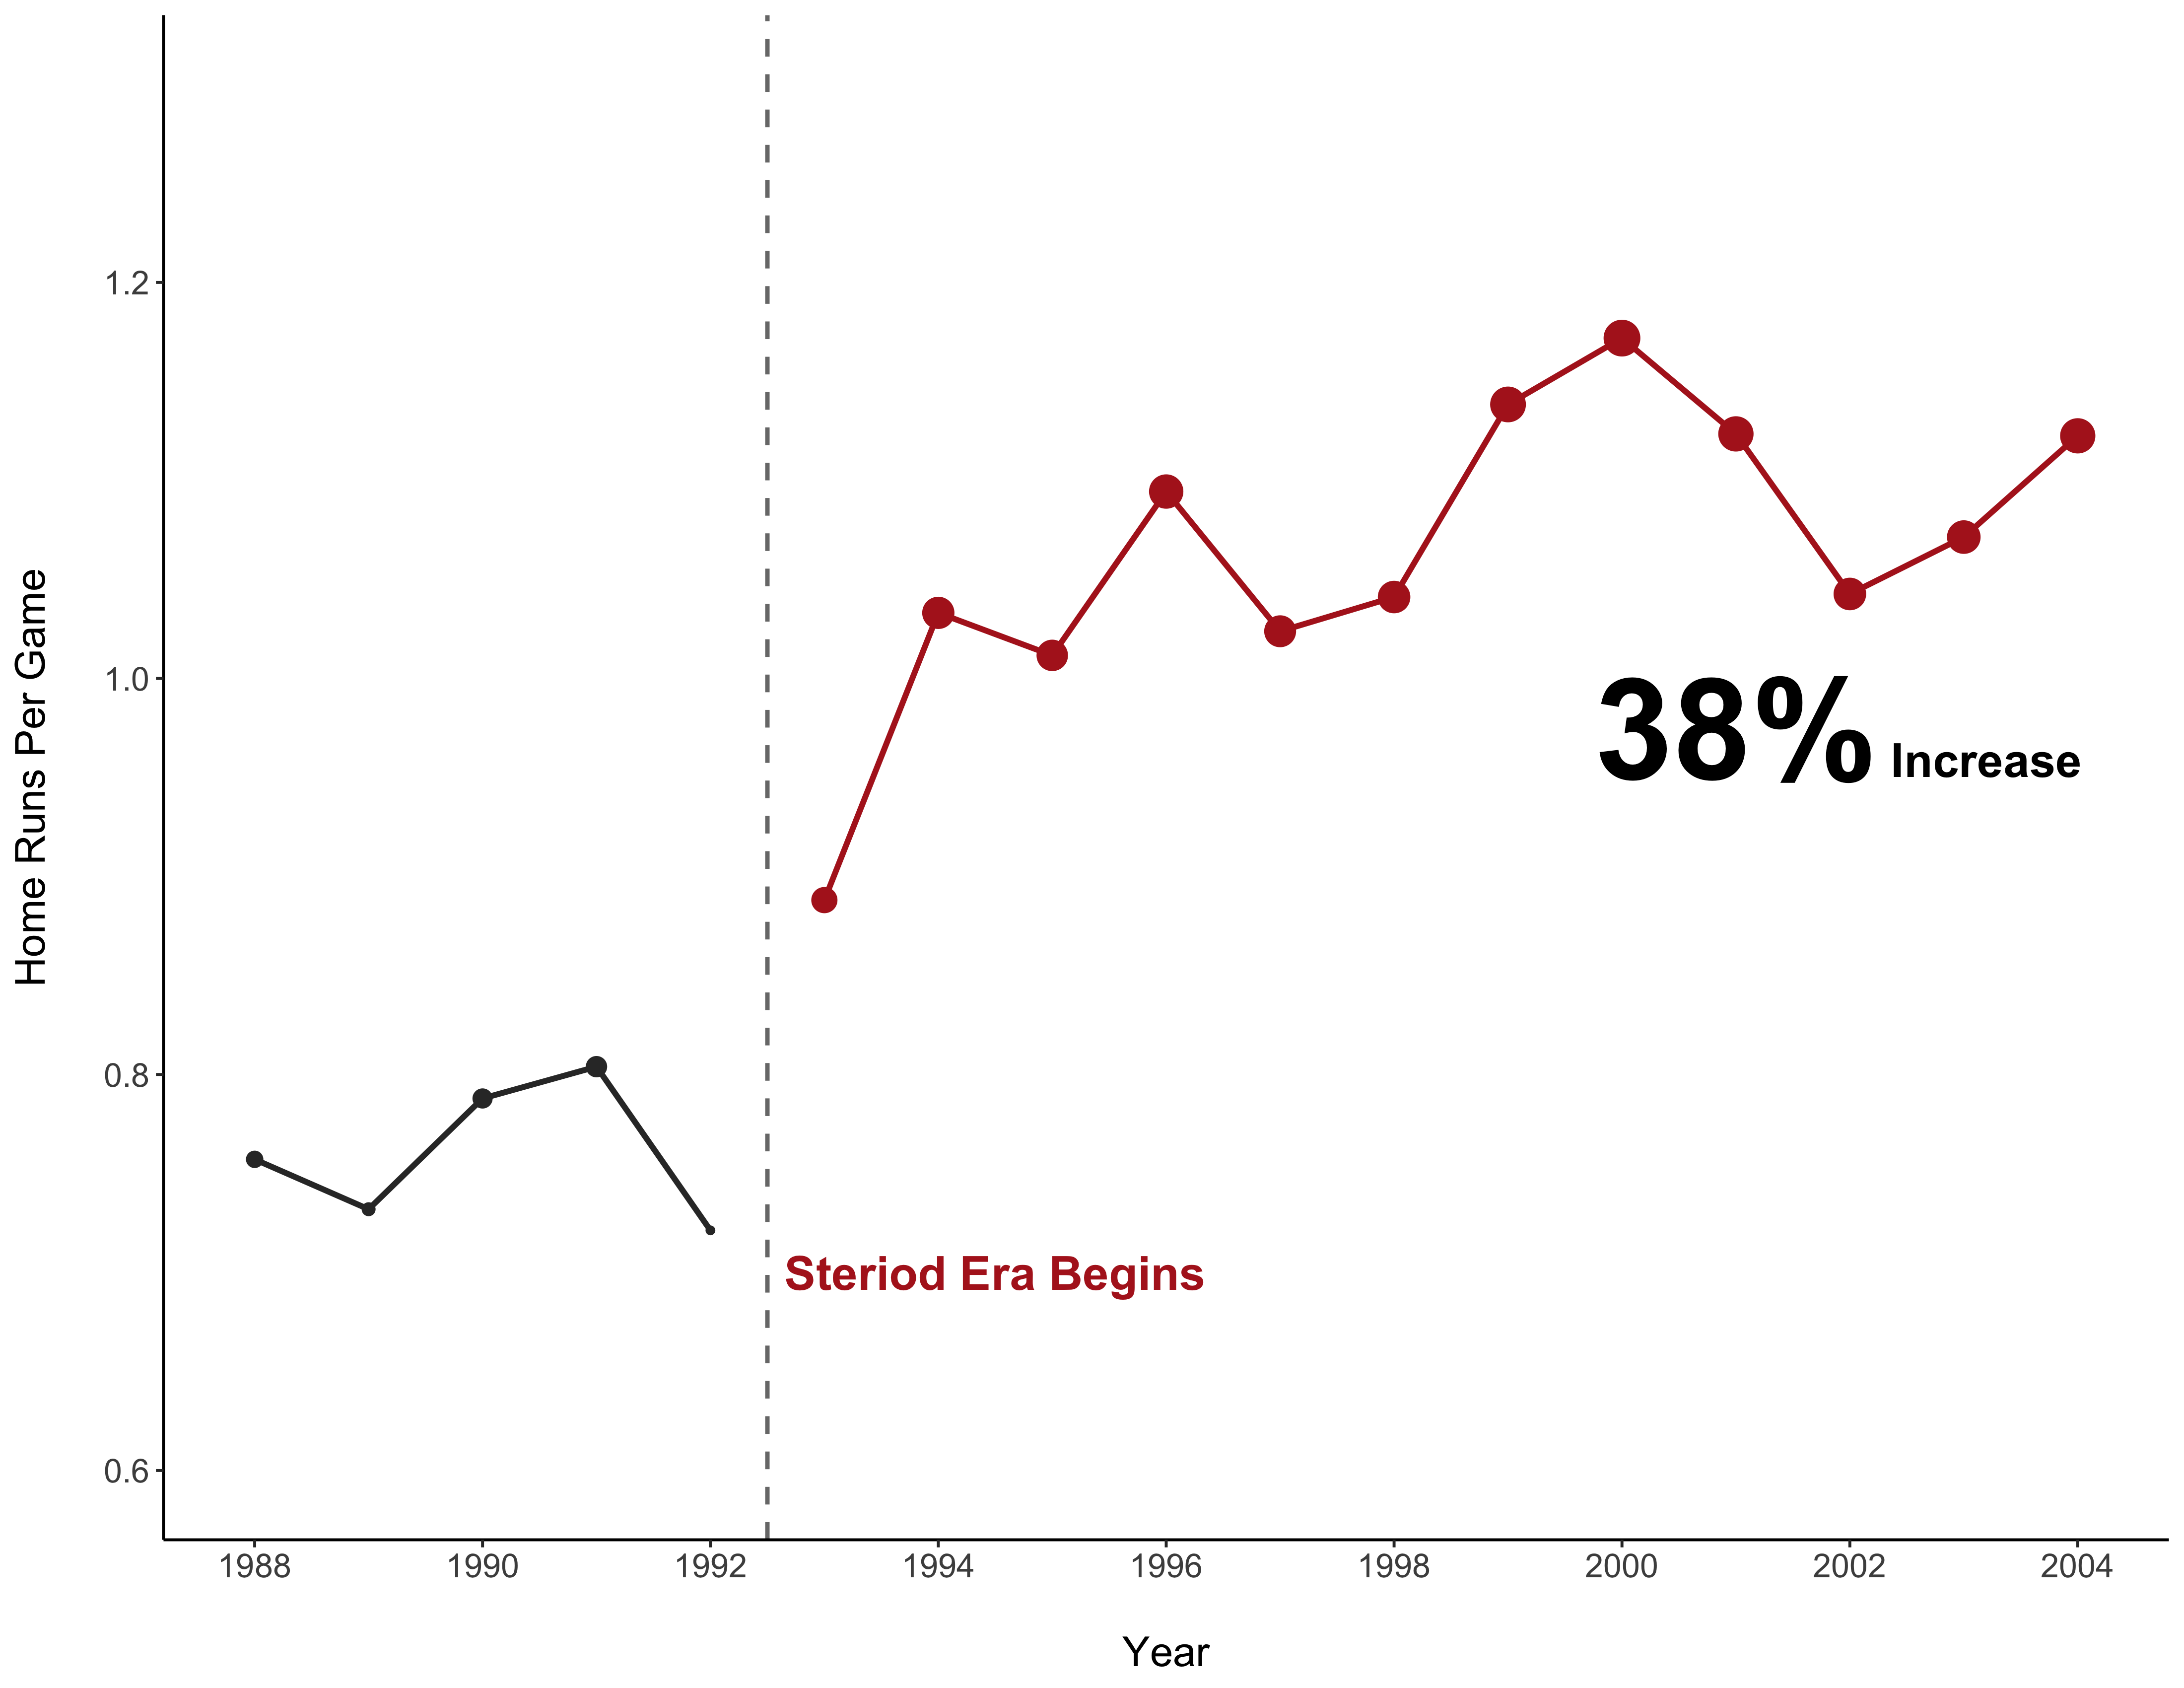

In [13]:
%%R -w 11 -h 8.5 --units in -r 400

ggplot() +
    geom_point(aes(x = yearID, y = hr_G, color = steroidFlag, size = hr_G), data = era) +
    geom_line(aes(x = yearID, y = hr_G, color = steroidFlag), size = 1,  data = era) +
    geom_vline(aes(xintercept = 1992.5), linetype = 2, alpha = 0.6, size = 0.75) +
    annotate("text", x = 1994.5, y = 0.7, size = 6, color = 'firebrick',
                label = "Steriod Era Begins", fontface = 'bold') +
    annotate("text", x = 2001, y = 0.975, size = 18, color = 'black',
                label = "38%", fontface = 'bold') +
    annotate("text", x = 2003.2, y = 0.959, size = 6,label = "Increase", fontface = 'bold') +
    scale_color_manual(values = c('gray20', 'firebrick')) +
    scale_x_continuous(limits = c(1988, 2004), breaks = seq(1988, 2004, by = 2)) +
    scale_y_continuous(limit = c(0.6, 1.3), breaks = seq(0.6, 1.3, by = 0.2)) +
    xlab('\nYear') +
    ylab('Home Runs Per Game\n') +
    theme_classic() +
    guides(color = F, size = F) +
    theme(text = element_text(size = 15))

In [11]:
%R ggsave('../images/era.pdf', units = 'in', width = 11, height = 8.5, dpi = 400)